Note: If you modify any external Python modules (ex. in the optlearn library), to load the changes, be sure to restart the kernel before the next run.

Config

In [9]:
DATA_DIR = 'tsplib-data'
PROBLEMS_DIR = 'problems'
NP_DIR = 'npy'

# See the functions dict (line 478) in ./optlearn/optlearn/feature/features.py
# For any feature computation function named compute_fX_edges, you can add fX here
# DESIRED_EDGE_FEATURES = ['fg']
DESIRED_EDGE_FEATURES = ['fa', 'fb', 'fc', 'fd', 'fe', 'ff', 'fg', 'fi', 'fj']

# Uses fg weights of 1/iteration (1-indexed) instead of iteration/k
USE_PAPER_FG = True

# Even if the features already exist, overwrite them
OVERRIDE_FEATURES = True
if OVERRIDE_FEATURES:
	print('Warning: Any feature weights already computed may be overwritten.')

# Builds the labels directory along with the features directories
BUILD_LABELS = True

# Choose the layout function for arranging nodes in the visualizations
# Recommended choices: nx.spiral_layout, nx.spring_layout
import networkx as nx
VIZ_LAYOUT = nx.spiral_layout

Imports and Utility functions

In [10]:
import os
DATA_PATH = os.path.join(os.path.abspath(''), DATA_DIR)
PROBLEMS_PATH = os.path.join(DATA_PATH, PROBLEMS_DIR)
NP_PATH = os.path.join(DATA_PATH, NP_DIR)

import numpy as np
np.set_printoptions(linewidth=np.inf)

Plotting utilities (required for visualizations)

In [11]:
from optlearn.graph_utils import get_edges, get_weights
from optlearn.io_utils import optObject

import matplotlib.pyplot as plt

PYPLOT_W, PYPLOT_H = 4, 4 # in inches
ARC_RADIUS = 0.15

class TSPPlotData:
	def __init__(self, G: nx.Graph | nx.DiGraph):
		self.G = G
		self.edges = get_edges(G)
		self.pos = VIZ_LAYOUT(G)
		self.weights = get_weights(G)
	
	def plot(self, edge_values_list, ax=None, use_alpha=False):
		nx.draw_networkx_nodes(self.G, self.pos, ax=ax)
		nx.draw_networkx_labels(self.G, self.pos, font_size=10, font_color='w', ax=ax)
		connectionstyle = 'arc3' + (f',rad={ARC_RADIUS}' if self.G.is_directed() else '')
		nx.draw_networkx_edges(
			self.G,
			self.pos,
			edge_color=('black' if use_alpha else 'grey'),
			ax=ax,
			alpha=(edge_values_list.clip(0, 1) if use_alpha else 1),
			connectionstyle=connectionstyle
		)
		if not use_alpha:
			edge_labels = {}
			for edge_idx, edge in enumerate(self.edges):
				edge_labels[edge] = round(edge_values_list[edge_idx], 3)
			nx.draw_networkx_edge_labels(
				self.G,
				self.pos,
				edge_labels,
				label_pos=(0.3 if self.G.is_directed() else 0.5),
				bbox={"alpha": 0},
				ax=ax,
				connectionstyle=connectionstyle
			)
plot_cache: dict[str, TSPPlotData] = {}

Load Problems (required for visualizations)

In [12]:
for problem_file_name in os.listdir(PROBLEMS_PATH):
	print(f'Loading {problem_file_name}...')
	problem_name = problem_file_name.removesuffix('.tsp')
	problem_file_path = os.path.join(PROBLEMS_PATH, problem_file_name)
	# Returns graph with N(N - 1) edges (all directed edges besides loops)
	G = optObject().read_problem_from_file(problem_file_path).get_graph()
	plot_cache[problem_name] = TSPPlotData(G)

Loading small4_undirected.tsp...


Visualize problems (optional)

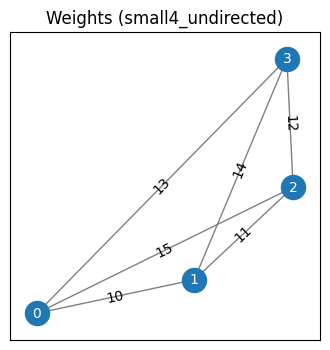

In [13]:
for problem_name, plot_data in plot_cache.items():
	plot_data.plot(plot_data.weights)
	plt.title(f'Weights ({problem_name})')
	plt.rcParams["figure.figsize"] = (PYPLOT_W, PYPLOT_H)
	plt.show()

Building features

In [14]:
import optlearn.mst.mst_model
optlearn.mst.mst_model.use_paper_fg = USE_PAPER_FG

import optlearn.data.data_utils
optlearn.data.data_utils.build_labels = BUILD_LABELS

import numpy as np
np.set_printoptions(linewidth=np.inf)

from optlearn.experiments.build_data import build_features
build_features(
	NP_PATH,
	PROBLEMS_PATH,
	DESIRED_EDGE_FEATURES,
	override=OVERRIDE_FEATURES
)


Status:
Directory Status: Checked/Built


Iteration 1 of 2
Iteration 2 of 2
Building problem!
Setting variables!
Setting objective!
Setting constraints!
Constraints set!
Solving problem!
presolving:
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present (symcode time: 0.00)
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 6 variables (0 bin, 0 int, 0 impl, 6 cont) and 4 constraints
      4 constraints of type <linear>
Presolving Time: 0.00

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
* 0.0s|     1 |     0 |     4 |     - |    LP  |   0 |   6 |   4 |   4 |   0 |  0 |   0 |   0 | 4.600000e+01 | 4.600000e+01 |   0.00%| unknow

Load features (required for pretty-printing/vizualization)

In [15]:
from optlearn.data.data_utils import dataLoader
# FULL_FEATURE_NAMES = [f'compute_{name}_edges' for name in DESIRED_EDGE_FEATURES]
loader = dataLoader([]) # how can we input the data_pairs if we don't have the data yet?
for problem_name, plot_data in plot_cache.items():
	plot_data.features_data = loader.load_features([
		os.path.join(NP_PATH, feature, problem_name + '.npy')
		for feature in DESIRED_EDGE_FEATURES])

Pretty-print features in a table

In [16]:
from tabulate import tabulate
for problem_name, plot_data in plot_cache.items():
	print(f'{problem_name}:')
	print(tabulate(
		plot_data.features_data,
		headers=DESIRED_EDGE_FEATURES,
		showindex=enumerate(plot_data.edges)
	))

small4_undirected:
                 fa      fb        fc        fd        fe        ff    fg    fi       fj
-----------  ------  ------  --------  --------  --------  --------  ----  ----  -------
(0, (0, 1))  0.6875  0.6875  0.733333  1         1         1          1    -0     0
(1, (0, 2))  1       1       1         0.6875    0.6875    0.75       0.5  -0     0
(2, (0, 3))  0.875   0.875   0.933333  0.785714  0.785714  0.928571   0.5  -0     0
(3, (1, 2))  0.75    0.8     0.75      0.916667  0.916667  1          1    -0     0
(4, (1, 3))  0.9375  1       1         0.733333  0.733333  0.866667   0.5   1     1
(5, (2, 3))  0.8125  0.8125  0.866667  0.846154  0.923077  1          1    -0.4  -0.1914


Printing and visualizing features

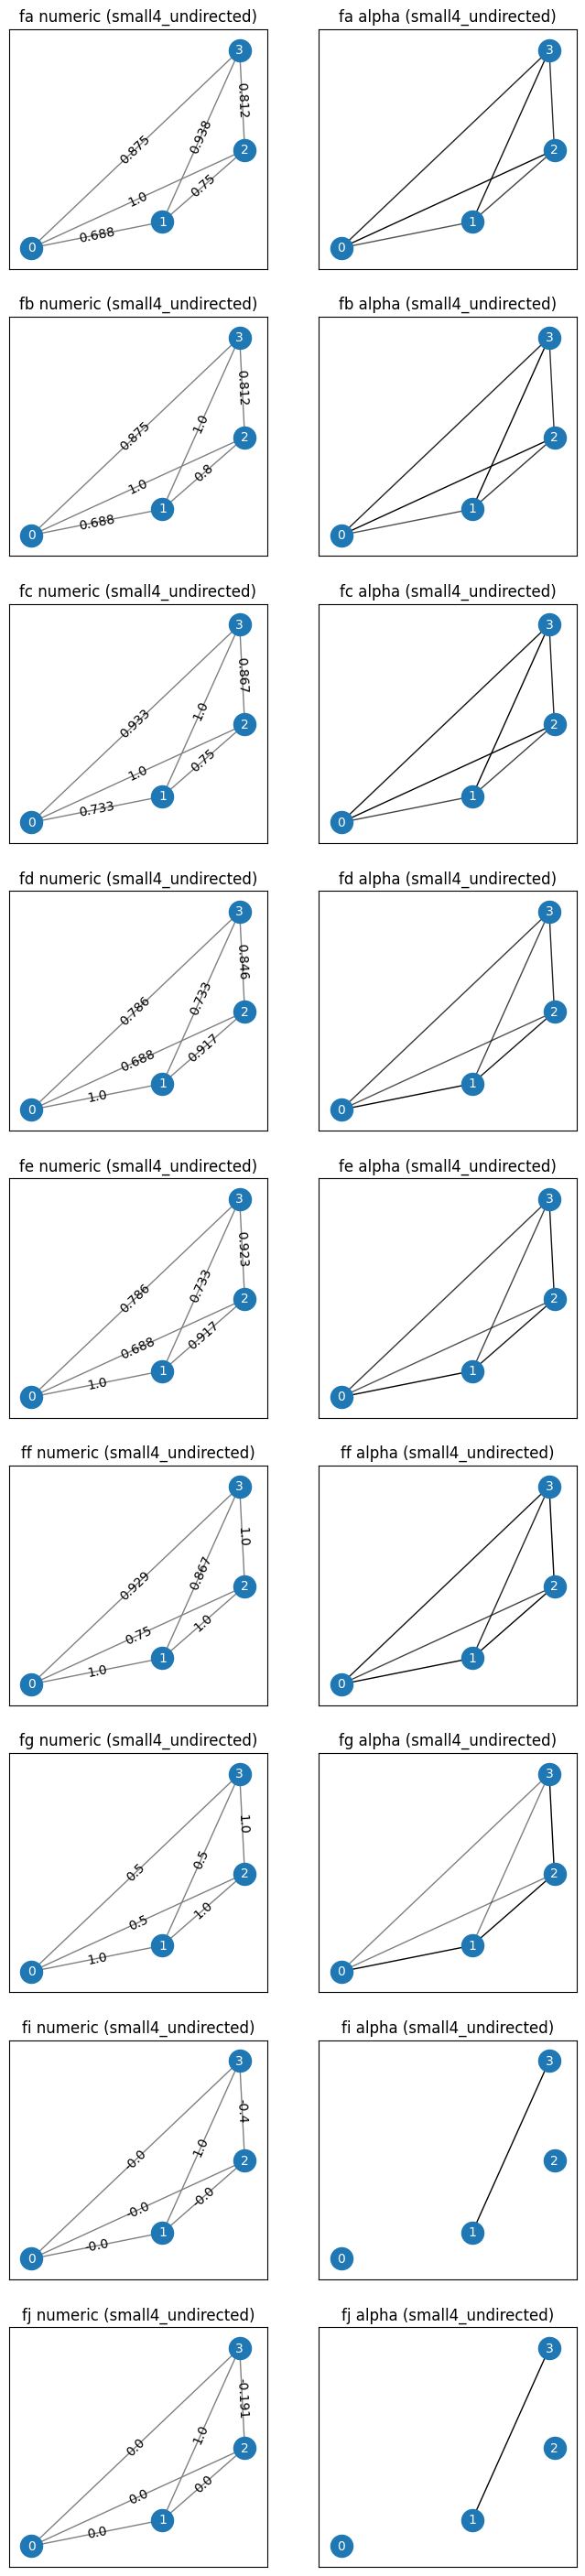

In [17]:
for problem_name, plot_data in plot_cache.items():
	# Based on
	# https://networkx.org/documentation/latest/auto_examples/drawing/plot_multigraphs.html#sphx-glr-auto-examples-drawing-plot-multigraphs-py
	fig, ax = plt.subplots(len(DESIRED_EDGE_FEATURES), 2)
	# Standardizes ax as a 2D list
	if len(DESIRED_EDGE_FEATURES) == 1:
		ax = [ax]

	for feature_idx, feature in enumerate(DESIRED_EDGE_FEATURES):
		ax_numeric: plt.Axes = ax[feature_idx][0]
		feature_data = plot_data.features_data[:,feature_idx]
		plot_data.plot(feature_data, ax=ax_numeric)
		ax_numeric.set_title(f'{feature} numeric ({problem_name})')

		ax_alpha: plt.Axes = ax[feature_idx][1]
		plot_data.plot(feature_data, ax=ax_alpha, use_alpha=True)
		ax_alpha.set_title(f'{feature} alpha ({problem_name})')
	
	fig.set_size_inches(PYPLOT_W * 2, PYPLOT_H * len(DESIRED_EDGE_FEATURES))
	plt.show()
